In [1]:
! rm -r runs

# import pickle
# import random
# from collections import namedtuple

import gym
import gym_point
import numpy as np
# import ptan
import torch
import torch.optim as optim
# from ptan.agent import float32_preprocessor

from util import PGN, RewardNet, GRL, float32_preprocessor

from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [2]:
GAMMA = 0.99
LEARNING_RATE = 0.0001
EPISODES_TO_TRAIN = 4
DEMO_BATCH = 50
seed = 0
np.random.seed(seed)
# random.seed(seed)
torch.manual_seed(seed)

In [3]:
env = gym.make('PointContinuousEnv-v0')
agent_net = PGN(env.observation_space.shape[0], env.action_space.n)
reward_net = RewardNet(env.observation_space.shape[0] + 1)
optimizer_agent = optim.Adam(agent_net.parameters(), lr=LEARNING_RATE)
optimizer_reward = optim.Adam(reward_net.parameters(), lr=1e-2, weight_decay=1e-4)

/home/sagrawal/src/gym/gym/logger.py:30: UserWarning: WARN: The dimensions are bigger than 2, only the first 2 dimensions are visualized
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Total number of demonstrations:  10
Total number of step demonstrations:  1000


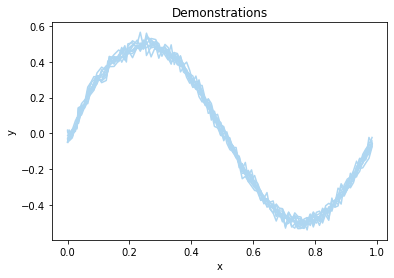

In [4]:
grl = GRL(env, noise=0.02)
demonstrations, XStore_steps, AStore_steps = grl.get_demonstrations(Ndemo=10)
# grl.test_demonstrations(demonstrations, Nsamp=5)
# demonstrations['states'][0][:10], demonstrations['actions'][0][:10]

In [49]:
x = torch.cat([float32_preprocessor(states), float32_preprocessor([int(actions)])]).view(1, -1)
print(x)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

In [36]:
total_rewards = []
step_idx = 0
done_episodes = 0

BSIZE = 100 # batch size

batch_episodes = 0
batch_states, batch_actions, batch_qvals = deque([], BSIZE), deque([], BSIZE), deque([], BSIZE)
cur_rewards = []
env_rewards = []
loss_rwd = 0.
env_rewards = 0

for step_idx in range(100):
    states, actions, rewards, done = agent_net.generate_session(env, 100)
    
    # Store samples in batch
    batch_states.extend(states)
    batch_actions.extend(actions)
    batch_qvals.extend(gcl.calc_qvals(rewards))
    
    env_rewards = np.sum(rewards)
    
    if len(batch_actions) < 100:
        continue
        
    # Get reward from reward_net
    x = torch.cat([float32_preprocessor(states[0]), float32_preprocessor([int(actions[0])])]).view(1, -1)
    reward = reward_net(x)
    cur_rewards.append(reward.item())
        
    if done is True:        
        cur_rewards.clear()
        batch_episodes += 1
        done_episodes += 1
        
        total_rewards.append(env_rewards)
        mean_rewards = float(np.mean(total_rewards[-100:]))
        
        writer.add_scalar('Episodic Reward', reward, done_episodes)
        writer.add_scalar('mean_reward', mean_rewards, done_episodes)
        writer.add_scalar('loss_reward_net', loss_rwd, done_episodes)        
        
        print(f'{step_idx}: reward: {env_rewards:6.2f}, mean_100: {mean_rewards:6.2f}, '
              f'episodes: {done_episodes}, reward function loss: {loss_rwd:6.4f}')
        
        ## Tensorboard logging 
        if done_episodes%100==0 or mean_rewards>=80:
            fig = reward_net.visualize_net(agent_net, Npoints=20)
            writer.add_figure('Reward Net', fig, global_step=done_episodes/100)
            
        if mean_rewards >= 80:
            print(f'Solved in {step_idx} steps and {done_episodes} episodes!')
            torch.save(agent_net.state_dict(), 'pointspace_learner.mod')
            torch.save(reward_net.state_dict(), 'pointspace-v1_reward_func.mod')
            break

    states_v = torch.FloatTensor(batch_states)
    batch_actions_t = torch.LongTensor(batch_actions)
    batch_qvals_v = torch.FloatTensor(batch_qvals)
  
    demo_states = np.array(demonstrations['states'])
    demo_actions = np.array(demonstrations['actions'])
    for rf_i in range(10):
        # reward function learning

#         selected = np.random.choice(len(demonstrations), DEMO_BATCH)
        selected = np.random.choice(50, DEMO_BATCH)
        demo_states = demo_states[selected]
        demo_actions = demo_actions[selected]
        demo_batch_states, demo_batch_actions = [], []
    
        for idx in range(len(demo_states)):
            demo_batch_states.extend(demo_states[idx])
            demo_batch_actions.extend(demo_actions[idx])
        
        demo_batch_states = torch.FloatTensor(demo_batch_states)
        demo_batch_actions = torch.FloatTensor(demo_batch_actions)
        
        D_demo = torch.cat([demo_batch_states, demo_batch_actions.view(-1, 1)], dim=-1)
        D_samp = torch.cat([states_v, batch_actions_t.float().view(-1, 1)], dim=-1)
        D_samp = torch.cat([D_demo, D_samp])
        
        
        # dummy importance weights - fix later
        z = torch.ones((D_samp.shape[0], 1))

        # objective
        D_demo_out = reward_net(D_demo)
        D_samp_out = reward_net(D_samp)
        D_samp_out = z * torch.exp(D_samp_out)
        
        loss_rwd = -torch.mean(D_demo_out) + torch.log(torch.mean(D_samp_out))
        loss_rwd = 10000*loss_rwd  # for maximization

#         # Case 1
#         Demo = 8
#         Samp = 80
#         Bad Reward Net
#         Loss = -(8 - 80) = 72
        
#         # Case 2
        
        # update parameters
        optimizer_reward.zero_grad()
        loss_rwd.backward()
        optimizer_reward.step()

    # agent
    optimizer_agent.zero_grad()
    logits_v = agent_net(states_v)
    log_prob_v = torch.log_softmax(logits_v, dim=1)
    
    # REINFORCE
    log_prob_actions_v = batch_qvals_v * log_prob_v[range(len(batch_states)), batch_actions_t]
    loss_v = log_prob_actions_v.mean()
    
    # Todo: add loss to tensorboard
    
    loss_v.backward()
    optimizer_agent.step()

    batch_episodes = 0
#     batch_states.clear()
#     batch_actions.clear()
#     batch_qvals.clear()
env.close()
writer.close()

IndexError: index 13 is out of bounds for axis 0 with size 10

In [44]:
grl.calc_qvals(rewards)

[1.0099, 0.010000000000000009, -1.0]

In [20]:
c.clear()

In [21]:
c

[]